# PPO

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
import gymnasium
import matplotlib.pyplot as plt

目标函数中的baseline部分是

$$
\begin{align}
\max_{\theta} \hat{\mathbb{E}}_{t} \left[ \frac{\pi_{\theta}(a_{t} | s_{t})}{\pi_{\theta_{\text{old}}}(a_{t} | s_{t})} A_{t} \right]
\end{align}
$$

其中 
- $A_t = Q(a_t, s_t) - V(s_t)$, 即在状态 $s_t$ 时采取动作 $a_t$ 的价值与平均价值 $V(s_t)$ 相比的增量（可为负） 
- $\frac{\pi_{\theta}(a_{t} | s_{t})}{\pi_{\theta_{\text{old}}}(a_{t} | s_{t})}$ 是 $\pi_{\theta}(a_t|s_t)$ 与原 policy 下动作 $a_t$ 的概率相比的倍数

同时为了限制每次更新的步子不要迈的太大，有三种方式：

#### 第一种：TRM

其实就是用KL散度搞一个惩罚项，限制新的 $\pi_\theta$ 和旧的policy 不能差距太大。

#### 第二种: CSO

直接对更新率的范围做限制，超过限制了就截断：

$$
\begin{align}
\mathcal{L}^{CLIP}(\theta)= \hat{\mathbb{E}}_{t}  \left[ \min\left( r_i(\theta) \hat{A_t}, \text{clip}\big( r_t(\theta), 1 - \epsilon, 1 + \epsilon \big) \right) \right]
\end{align}
$$

需要注意的是， 这个clip 函数是需要根据 $A_t$ 的正负性来做出不同的动作的， 如果$A_t$ 为正， 则只在上界 $1+\epsilon$ 处做截断，反之则在 $1-\epsilon$ 处做截断，毕竟这个函数的目的是防止更新的步子迈太大，而A为正的时候max算法会想尽办法增大$r_t$， 所以要对上限做限制，A_t为负的时候max算法会想尽办法让这个减少量尽可能小，所以会尽可能减少$r_t$，所以限制系数下限

#### 第三种：Adaptive KL Penalty Coefficient

就是TRM的会自动调整 KL项系数的版本，当算法表现偏离目标散度值太多的时候就紧紧缰绳：

- 如果更新过程中发现散度小于 $\frac{目标散度值}{1.5}$， 说明KL散度项对优化的权重有点高了，则调整KL项系数为之前的一半
- 如果更新过程中发现散度大于 $目标散度值 \times 1.5$， 说明KL散度限制得还不够，则调整KL项系数为之前的两倍



## 算法

首先是计算 $A_t$ 的方法，论文里使用的是

$$
\begin{align}
\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + \cdots + (\gamma \lambda)^{T-t-1} \delta_{T-1}
\end{align}
$$

其中

$$
\begin{align}
\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)
\end{align}
$$



其次是损失函数，因为训练过程还用到了神经网络（论文里用的是Actor-Critic）而且和policy的参数共用，所以损失函数还得涵盖神经网络的损失函数，则最终有：

$$
\begin{align}
\mathcal{L}(\theta) = \hat{\mathbb{E}_t}\left[L_t^{CLIP}(\theta) - c_1\mathcal{L_t}^{VF}(\theta) + c_2S(\pi_{\theta})(s_t) \right]
\end{align}
$$


算法伪代码如下：



In [19]:
'''
for epochs in range(epochs):
    for actor in N:
        先用旧的policy采样一批数据
        计算A_t
    用这些数据使用损失函数更新policy，我们下面程序里优化方法用的是 mini-batch SGD
    更新policy参数
'''

'\nfor epochs in range(epochs):\n    for actor in N:\n        先用旧的policy采样一批数据\n        计算A_t\n    用这些数据使用损失函数更新policy，我们下面程序里优化方法用的是 mini-batch SGD\n    更新policy参数\n'

## 先造一个 actor-critic model

In [4]:
# 检查 cuda 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')


print(f'cuda.is_available: {torch.cuda.is_available()}')
print(f'device: {device}')
if torch.cuda.is_available():
    print(f'device_name: {torch.cuda.get_device_name(0)}')

print(f'version.cuda: {torch.version.cuda}')
print(f'torch.version: {torch.__version__}')
print(f'cudnn.version: {torch.backends.cudnn.version()}')
print(f'cudnn.enabled: {torch.backends.cudnn.enabled}')


cuda.is_available: True
device: cuda:0
device_name: NVIDIA GeForce RTX 4090 D
version.cuda: 12.8
torch.version: 2.8.0+cu128
cudnn.version: 91002
cudnn.enabled: True


In [3]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        # 共享特征提取层
        self.shared_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
        )
        
        # 策略网络
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # 价值网络
        self.critic = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        features = self.shared_net(x)
        action_probs = self.actor(features)
        state_value = self.critic(features)
        return action_probs, state_value

### 接着是PPO CLIP版本

优化方法用的是 minibatch SGD

In [12]:
class PPO_CLIP():
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, gae_lambda=0.95, epsilon_clip=0.2, epochs=10, batch_size=64, T=1024, N=1, c_1=0.5, c_2=0.01):
        '''
        c_1: 价值函数损失的权重
        c_2: 熵正则化的权重
        '''
        # 初始化policy和优化器
        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # 算法超参数
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.epsilon_clip = epsilon_clip
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.T = T  
        self.N = N
        self.c_1 = c_1
        self.c_2 = c_2
        
        # 存储器
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_pi = []
        self.dones = []
        
    def store_transition(self, state, action, reward, done, value, log_pi):
        """存储transition到缓冲区"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)
        self.log_pi.append(log_pi)
        
    def clear_buffer(self):
        """储存器清空"""
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.values = []
        self.log_pi = []
        
    def get_action(self, state):
        '''
        根据当前policy返回动作等参数
        '''
        state = torch.FloatTensor(state).to(device).unsqueeze(0) # 保证state为张量
        with torch.no_grad():  # 添加no_grad避免计算图积累
            pi, state_value = self.policy(state) # 计算动作概率和状态价值，返回两个张量
            action = pi.multinomial(1) # 这里用的是随机采样，后期可换为最优概率
            log_prob = torch.log(pi[0, action.item()])
        return action.item(), state_value.item(), log_prob.item()
    
    def get_A_and_return(self):
        """计算GAE优势函数和回报"""
        A_ts = []
        returns = []
        gae = 0
        
        # 从后向前计算
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = 0  # 终止状态的价值为0
            else:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = self.values[t + 1]
            
            delta = self.rewards[t] + self.gamma * next_value * next_non_terminal - self.values[t]
            gae = delta + self.gamma * self.gae_lambda * next_non_terminal * gae
            A_ts.insert(0, gae)
            returns.insert(0, gae + self.values[t])
        
        advantages = torch.FloatTensor(A_ts).to(device)
        returns = torch.FloatTensor(returns).to(device)
        
        # 标准化优势函数
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        return advantages, returns
    
    def update(self): # minibatch SGD 更新 theta
        # 保证几个历史记录都为张量
        states = torch.FloatTensor(self.states).to(device)
        actions = torch.LongTensor(self.actions).to(device).unsqueeze(-1)
        old_log_pi = torch.FloatTensor(self.log_pi).to(device).unsqueeze(-1)
        
        A_ts, returns = self.get_A_and_return() # 计算 advantage function
        
        for k in range(self.epochs):
            indices = torch.randperm(len(states))
            for start in range(0, len(states), self.batch_size):
                end = start + self.batch_size
                batch_idx = indices[start:end]
                
                batch_states = states[batch_idx] 
                batch_actions = actions[batch_idx]
                batch_old_log_pi = old_log_pi[batch_idx]
                batch_A_ts = A_ts[batch_idx]
                batch_returns = returns[batch_idx]
                
                # 计算新的policy
                pi, values = self.policy(batch_states)
                distribution = Categorical(pi)
                new_log_pi = distribution.log_prob(batch_actions.squeeze())
                entropy = distribution.entropy().mean()
                
                # 计算 ratio
                ratio = torch.exp(new_log_pi - batch_old_log_pi.squeeze()) # pi_theta / pi_theta_k
                
                # objective function
                obj1 = ratio * batch_A_ts
                obj2 = torch.clamp(ratio, 1.0 - self.epsilon_clip, 1.0 + self.epsilon_clip) * batch_A_ts
                value_loss = nn.MSELoss()(values.squeeze(), batch_returns)
                policy_loss = -torch.min(obj1, obj2).mean()
                loss_function = policy_loss + self.c_1 * value_loss - self.c_2 * entropy
                
                # 反向传播
                self.optimizer.zero_grad()
                loss_function.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)  # 梯度裁剪
                self.optimizer.step()

def train():
    "根据论文里的伪代码实现PPO训练"
    env = gymnasium.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    algorithm = PPO_CLIP(state_dim, action_dim)
    episode_rewards = []
    
    for i in range(1000):  # 训练1000个回合
        for actor in range(algorithm.N):
            state, _ = env.reset()
            episode_reward = 0
            
            for t in range(algorithm.T):
                action, state_value, log_pi = algorithm.get_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                episode_reward += reward
                
                # 数据存入储存器
                algorithm.store_transition(state, action, reward, done or truncated, state_value, log_pi)
                
                state = next_state
                
                if done or truncated:
                    break
            episode_rewards.append(episode_reward)
            
        algorithm.update()  # 更新策略
        algorithm.clear_buffer()  # 清空储存器
        
        # 打印训练进度
        if i % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            print(f"Episode {i}, Average Reward: {avg_reward:.2f}")
        
    env.close()
    return episode_rewards

rewards = train()

Episode 0, Average Reward: 15.00
Episode 50, Average Reward: 28.34


/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100, Average Reward: 29.28
Episode 150, Average Reward: 42.76
Episode 200, Average Reward: 62.28
Episode 250, Average Reward: 70.20
Episode 300, Average Reward: 82.04
Episode 350, Average Reward: 87.30
Episode 400, Average Reward: 77.70
Episode 450, Average Reward: 82.20
Episode 500, Average Reward: 97.20
Episode 550, Average Reward: 93.32
Episode 600, Average Reward: 121.86
Episode 650, Average Reward: 115.92
Episode 700, Average Reward: 119.52
Episode 750, Average Reward: 122.98
Episode 800, Average Reward: 139.30
Episode 850, Average Reward: 159.18
Episode 900, Average Reward: 179.96
Episode 950, Average Reward: 105.50


Text(0.5, 1.0, 'PPO Training Rewards')

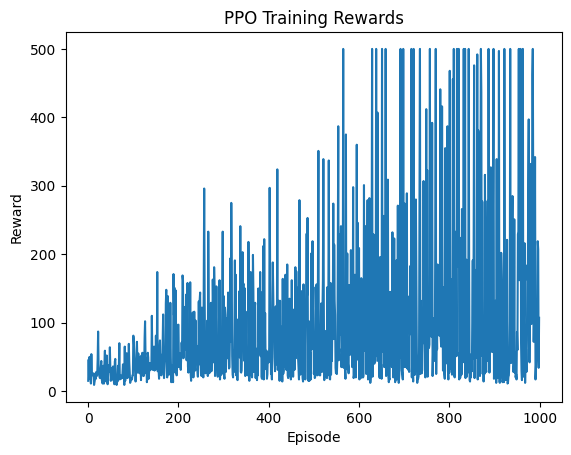

In [18]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO Training Rewards')